# UQ-TSS with Bayesian Online Changepoint Detection

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *
from arch.bootstrap import MovingBlockBootstrap
from arch.bootstrap import optimal_block_length
from arch.bootstrap import CircularBlockBootstrap
from arch.bootstrap import StationaryBootstrap
from numpy.random import standard_normal
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from typing import Optional, List
from scipy.io import arff
from scipy.stats import entropy
from scipy.signal import find_peaks
import ruptures as rpt
from scipy.signal import savgol_filter
from dbscan1d.core import DBSCAN1D
import stumpy
from stumpy.floss import _cac
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
import os
import re
from statsmodels.tsa.seasonal import STL
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
from numpy import array, linspace
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
from bayesian_changepoint_detection.hazard_functions import constant_hazard
from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll
from bayesian_changepoint_detection.priors import const_prior
from functools import partial
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')


## Load Datasets

In [9]:
datasets = []
m_settings = []
ground_truths = []

directory = "./data/datasets_seg/"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
        settings =  re.findall(r'_\d+', f)
        for i,setting in enumerate(settings):
            settings[i] = int(setting[1:])
        m_settings.append(settings[0])
        ground_truths.append(np.array(settings[1:]))
        ts = np.loadtxt(f, delimiter=",")
        datasets.append(ts)
datasets = np.array(datasets)
m_settings = np.array(m_settings)
ground_truths = np.array(ground_truths)

./data/datasets_seg/Cane_100_2345.txt
./data/datasets_seg/DutchFactory_24_2184.txt
./data/datasets_seg/EEGRat2_10_1000.txt
./data/datasets_seg/EEGRat_10_1000.txt
./data/datasets_seg/Fetal2013_70_6000_12000.txt
./data/datasets_seg/GrandMalSeizures2_10_4550.txt
./data/datasets_seg/GrandMalSeizures_10_8200.txt
./data/datasets_seg/GreatBarbet1_50_1900_3700.txt
./data/datasets_seg/GreatBarbet2_50_1900_3700.txt
./data/datasets_seg/InsectEPG1_50_3802.txt
./data/datasets_seg/InsectEPG2_50_1800.txt
./data/datasets_seg/InsectEPG3_50_1710.txt
./data/datasets_seg/InsectEPG4_50_3160.txt
./data/datasets_seg/NogunGun_150_3000.txt
./data/datasets_seg/PigInternalBleedingDatasetAirwayPressure_400_7501.txt
./data/datasets_seg/PigInternalBleedingDatasetArtPressureFluidFilled_100_7501.txt
./data/datasets_seg/PigInternalBleedingDatasetCVP_100_7501.txt
./data/datasets_seg/Powerdemand_12_4500.txt
./data/datasets_seg/PulsusParadoxusECG1_30_10000.txt
./data/datasets_seg/PulsusParadoxusECG2_30_10000.txt
./data/d

In [10]:
def UQTSS_BOCPD(data, ground_truth, sample_rate, n, hazard_settings, model_settings, print_info=True):
    filtered_data = filter_data(data, sample_rate)
    
    all_predictions = []
    all_coverings = []
    all_f1s = []
    
    for i in range(n):
        residuals = data-filtered_data
        noise =  np.random.default_rng().uniform(0.5,1.5,len(data))
        
      
        signal = filtered_data + (data-filtered_data)*noise


        p1 = random.randint(0, len(hazard_settings)-1)
        p2 = random.randint(0, len(model_settings)-1)
        p3 = random.randint(0, len(model_settings)-1)
        p4 = random.randint(0, len(model_settings)-1)
        
        hazard_function = partial(constant_hazard, int(hazard_settings[p1]))
        R, maxes = online_changepoint_detection(
            signal, hazard_function, online_ll.StudentT(alpha=model_settings[p2], beta=model_settings[p3], kappa=model_settings[p4], mu=0)
        )

        
        print(p1,p2,p3,p4)
        
        
        Nw=100
        plt.plot(R[Nw,Nw:-1])
        plt.show()
        predictions, _ = find_peaks(R[Nw,Nw:-1], height=0.5,distance=len(data)//10)
        #print(predictions)
        all_predictions.append(predictions)

        margin = 0.01*len(signal) +  sample_rate
        covering_score = covering(ground_truth, predictions, len(signal))
        all_coverings.append(covering_score)

        if print_info:
            print('covering score:', covering_score)


    all_predictions = np.array(all_predictions)
    all_coverings = np.array(all_coverings)
    return all_predictions, all_coverings


def filter_data(data, sample_rate):
    sample_rate = len(data)//500
    mask=np.ones((1,sample_rate)) /sample_rate
    mask=mask[0,:]
    filtered_data = np.convolve(data,mask,'same')
    filtered_data = np.squeeze(filtered_data)
    
    return filtered_data

4 1 2 1


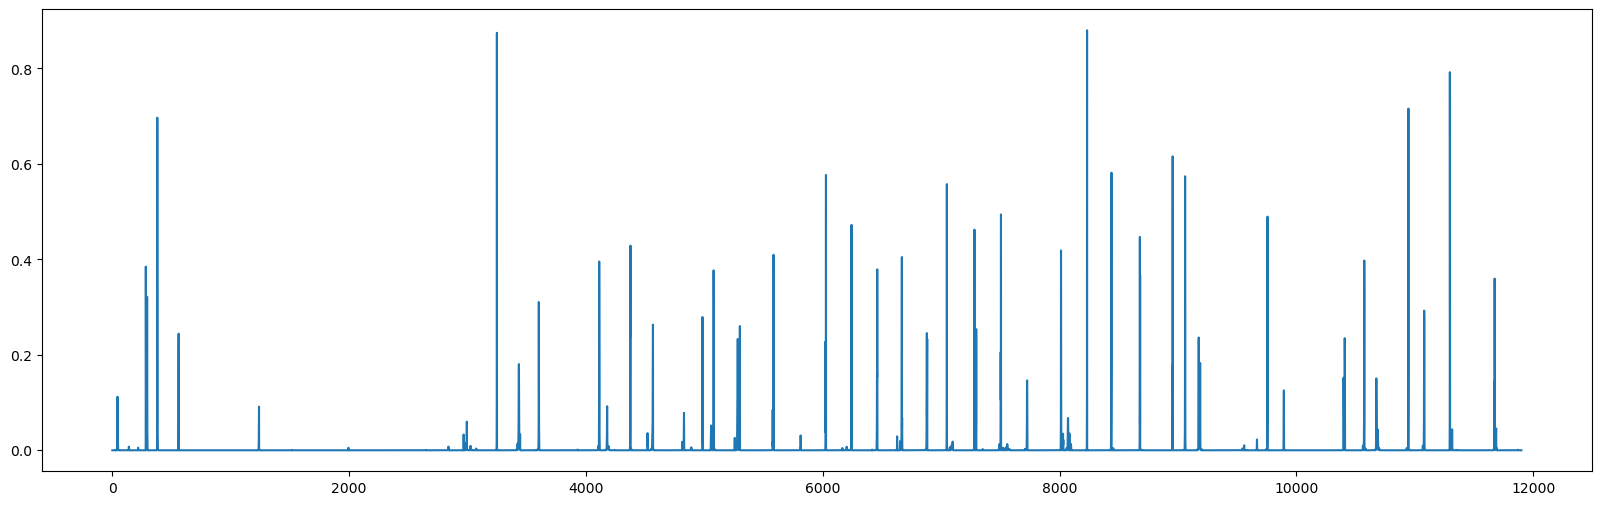

covering score: 0.4942921423214732
2 0 1 1


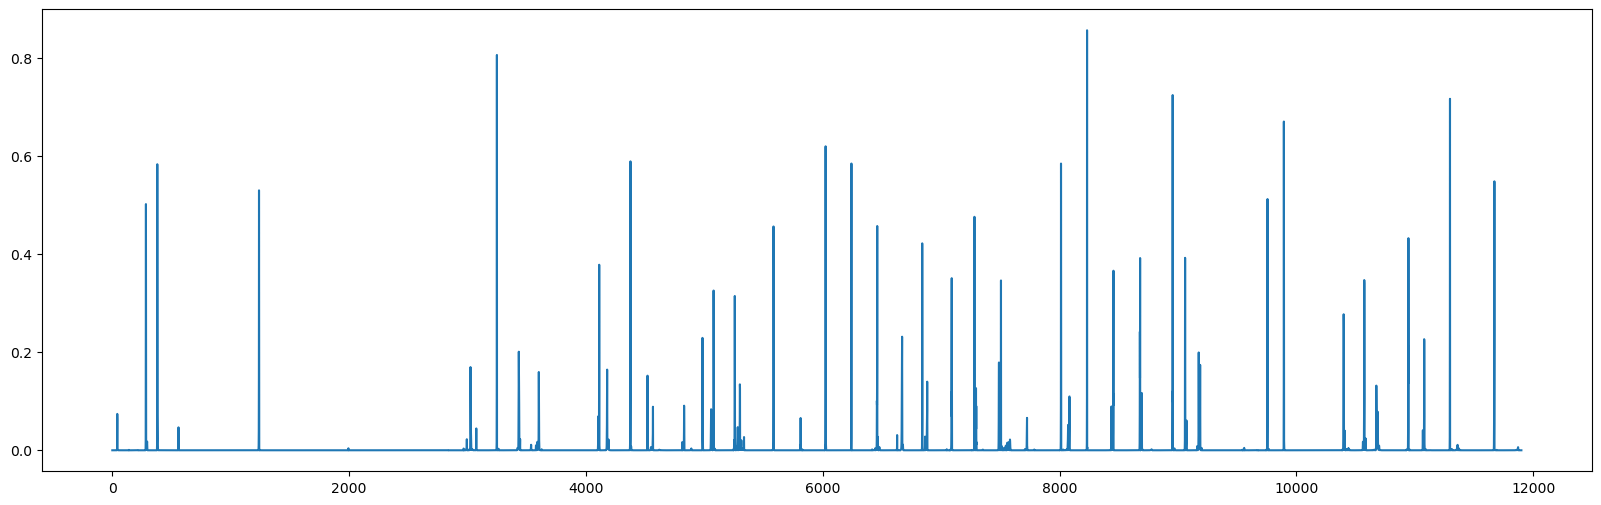

covering score: 0.4229647529372552
0 2 1 1


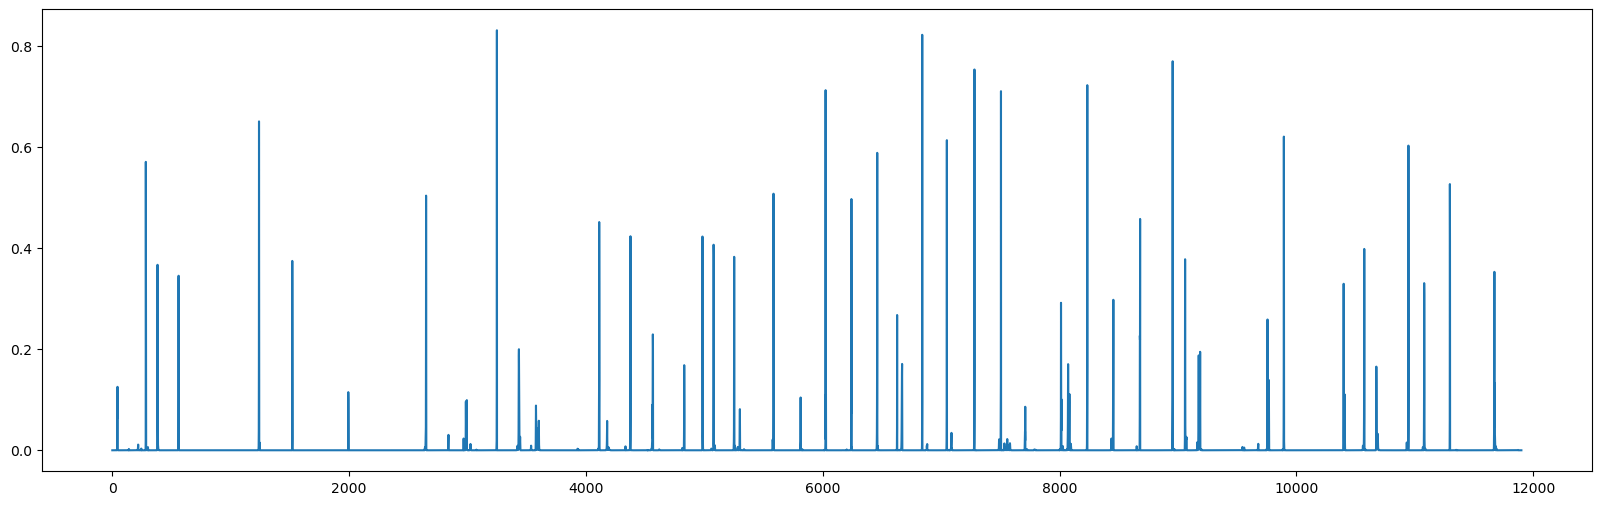

covering score: 0.343638030164153
3 0 1 1


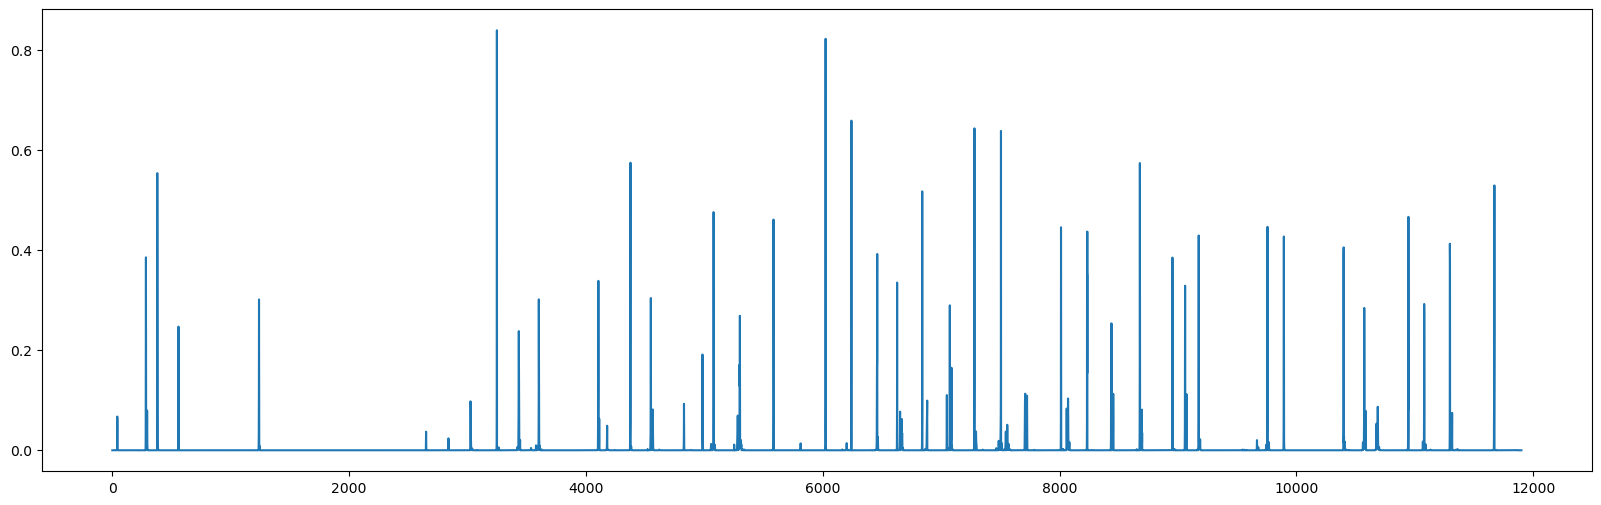

covering score: 0.4884592950587451
2 1 1 1


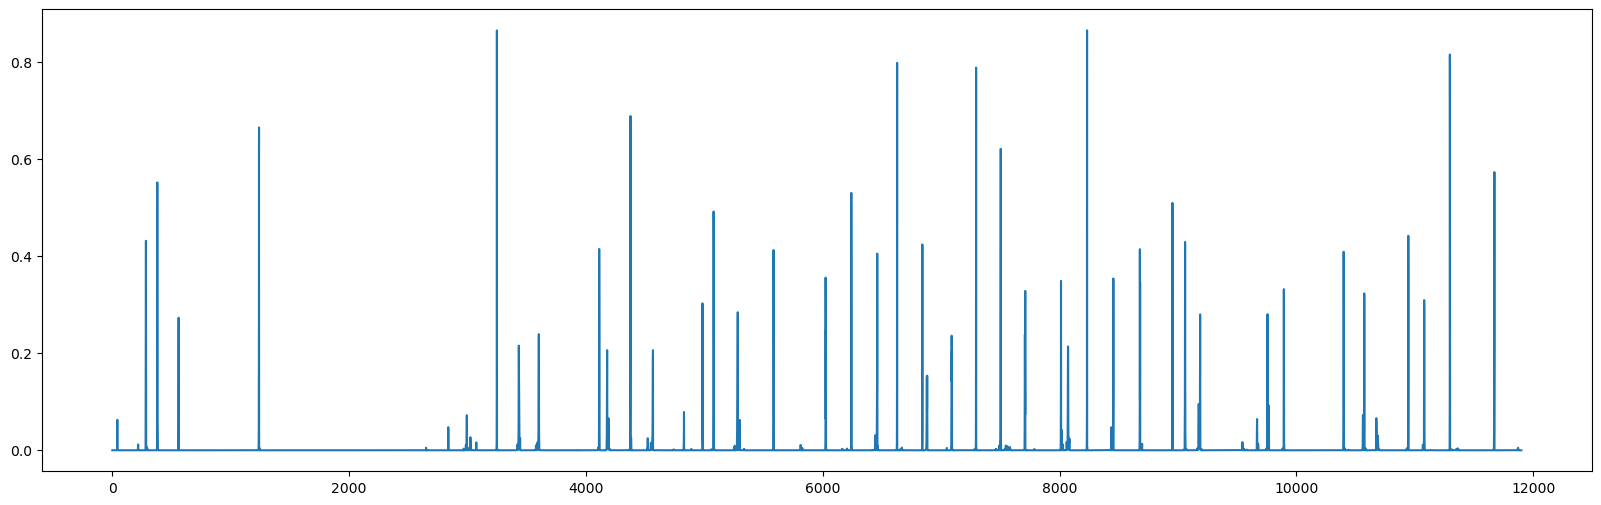

covering score: 0.4227147737688526
2 0 1 2


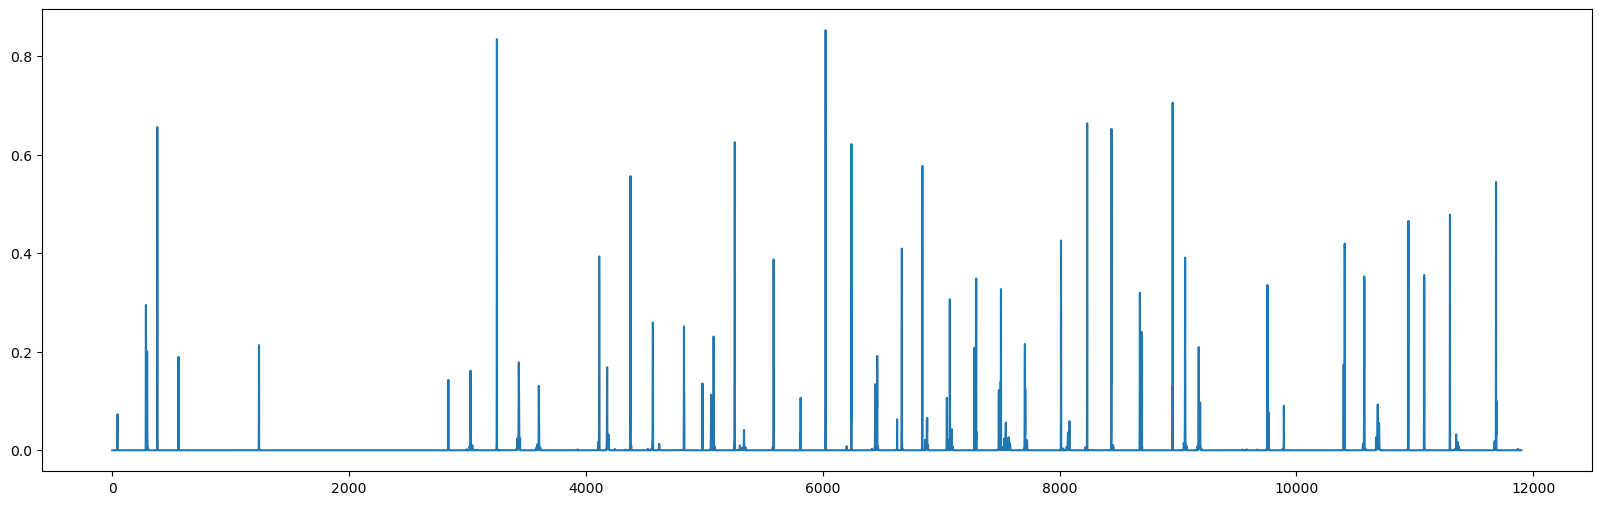

covering score: 0.4832097325222898
1 1 0 2


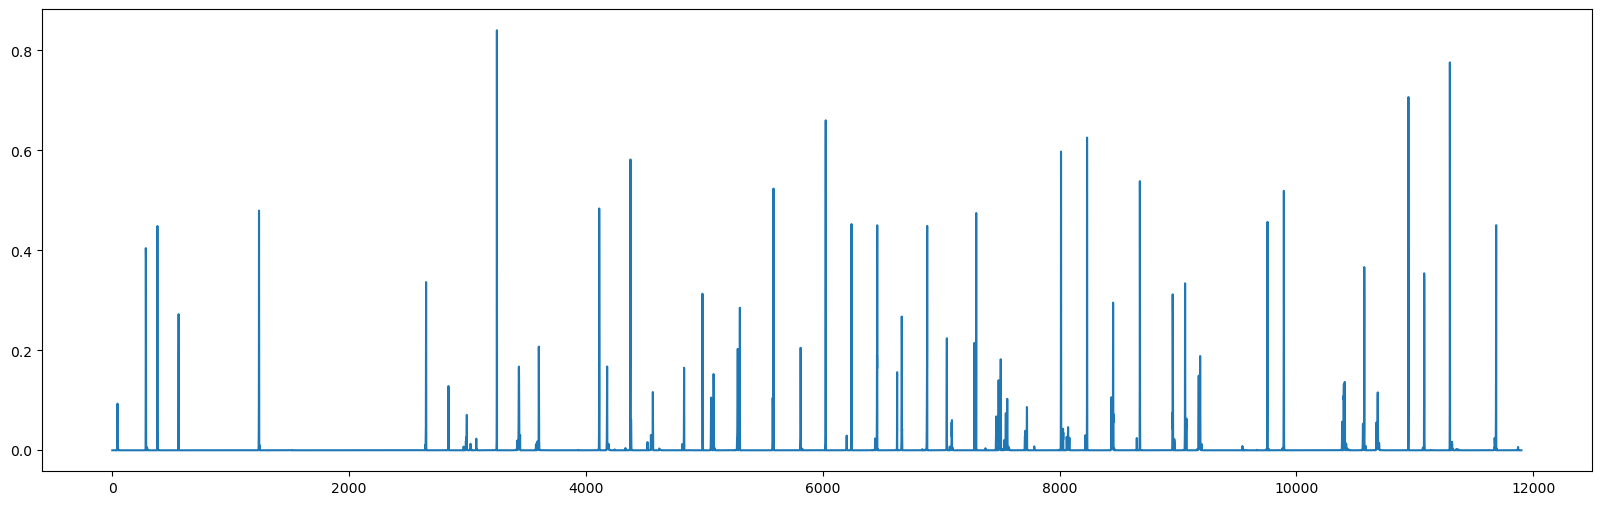

covering score: 0.45454545454545453
2 2 2 1


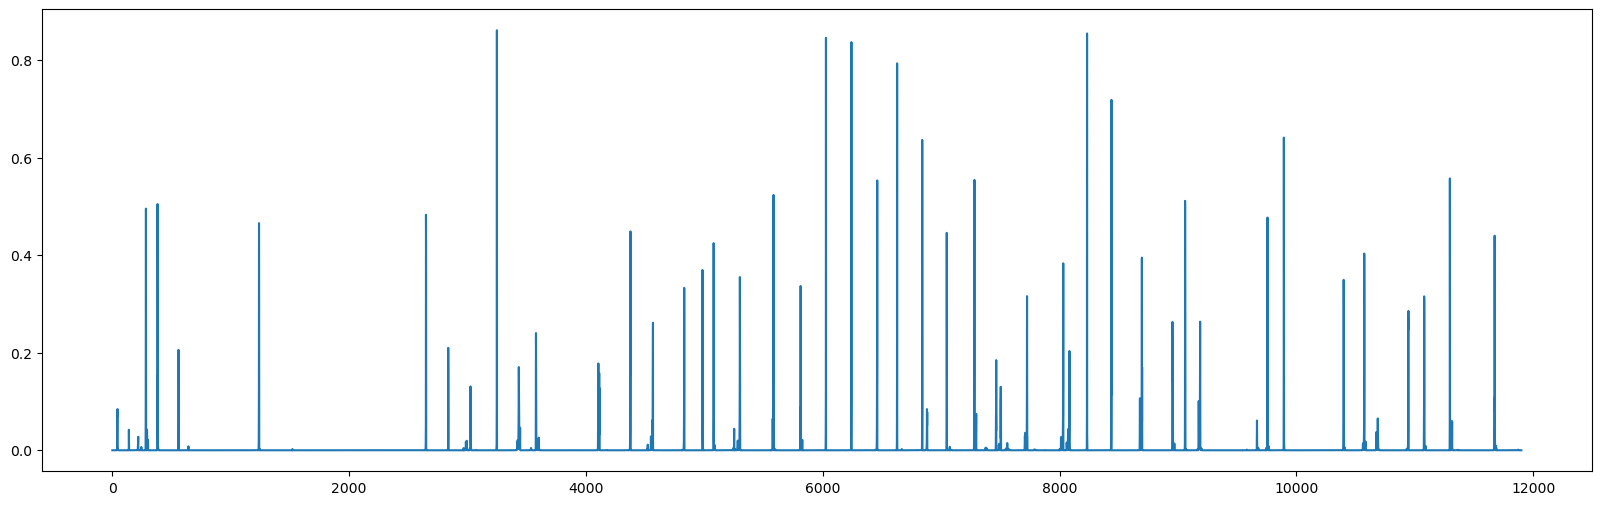

covering score: 0.4225481209899175
2 2 0 0


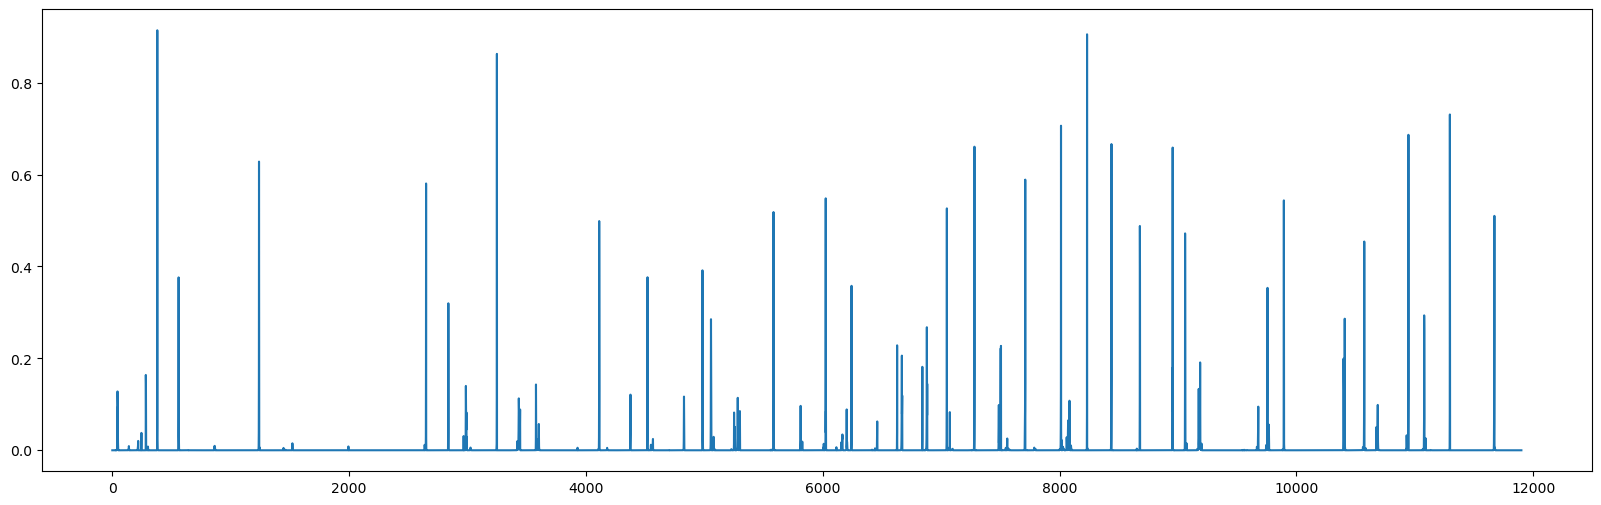

covering score: 0.4228814265477877
1 1 2 1


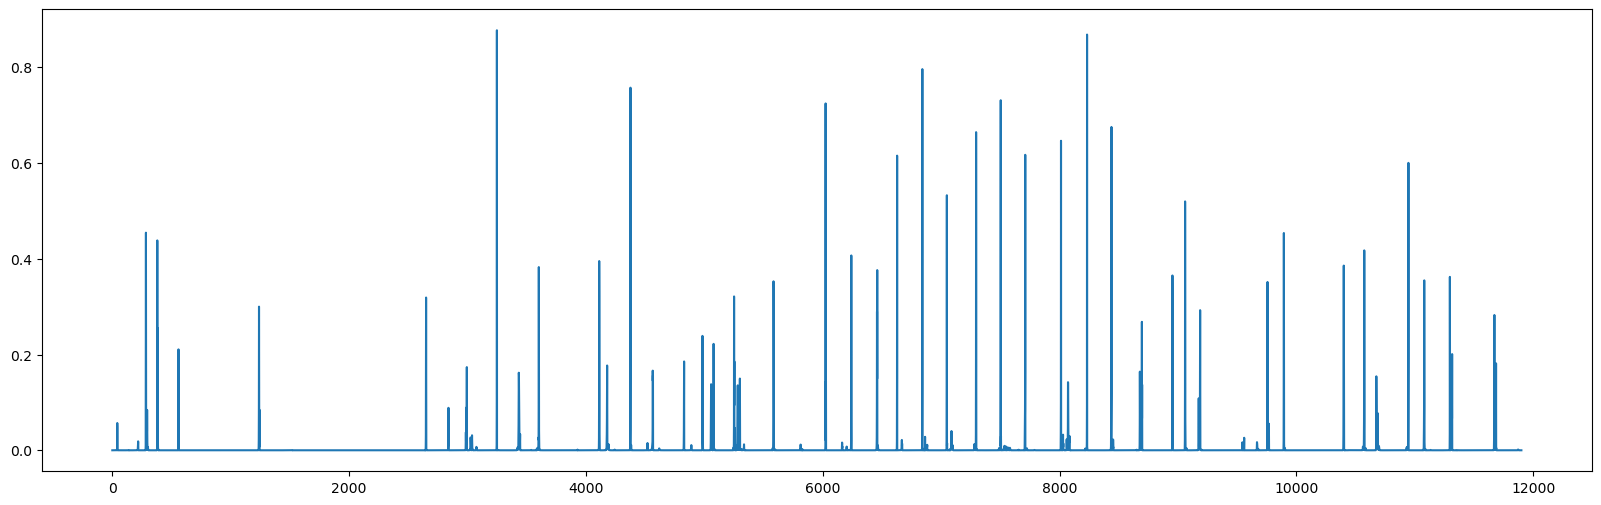

covering score: 0.49679193400549954
3 0 2 2


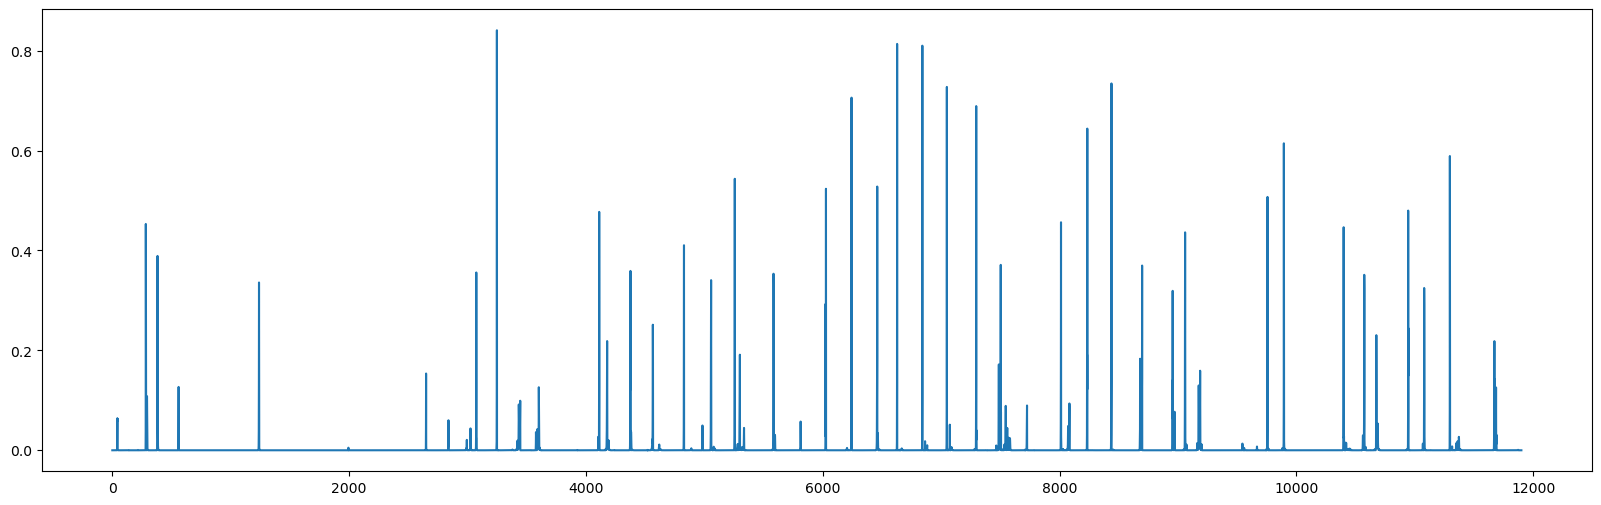

covering score: 0.42146487792683945
1 0 2 2


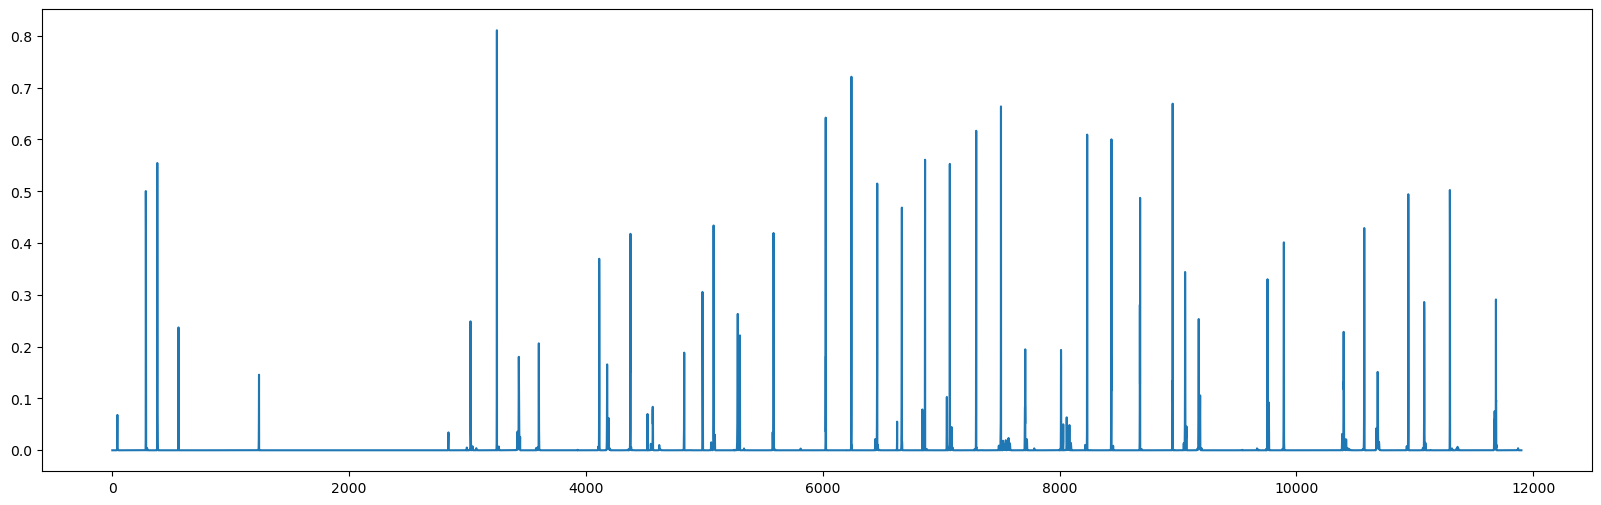

covering score: 0.4340471627364386
3 2 2 0


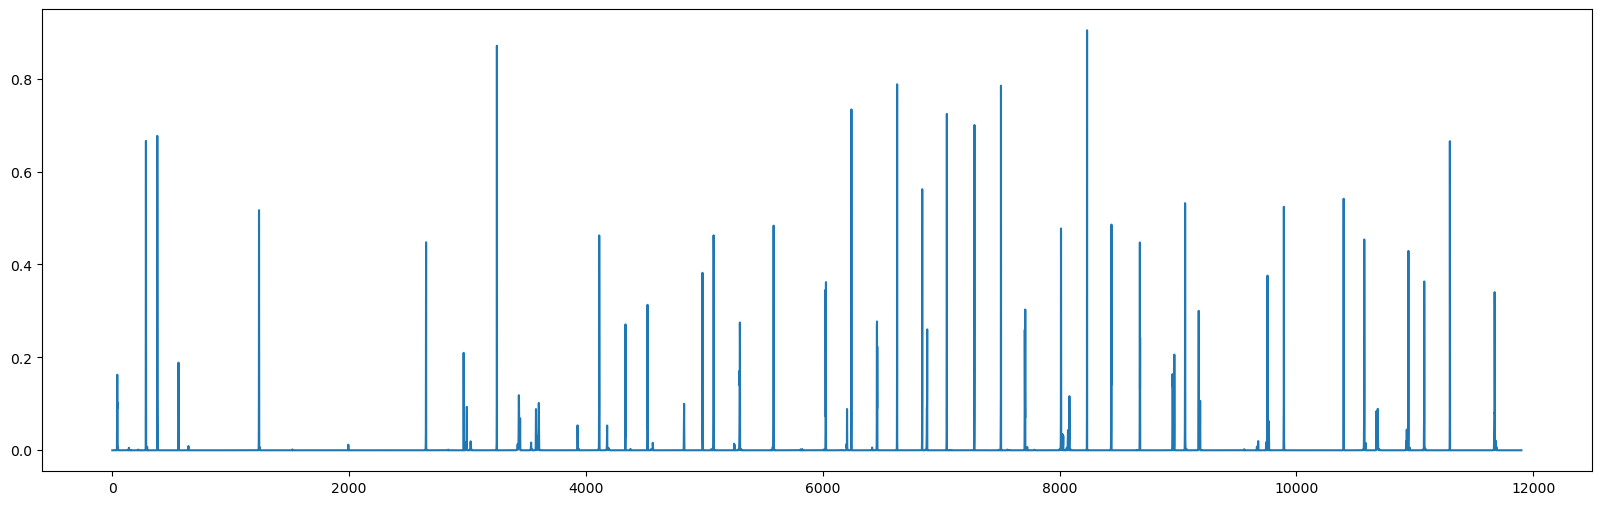

covering score: 0.386376100098974
1 0 2 0


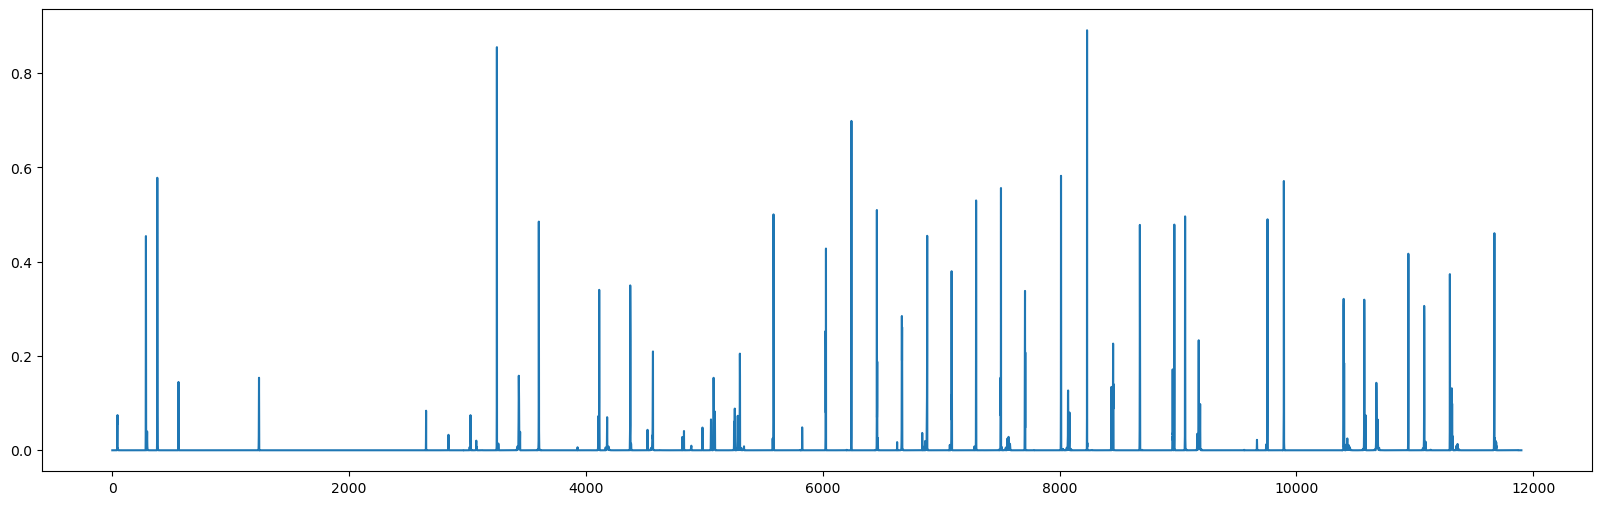

covering score: 0.41454878760103325
1 0 0 1


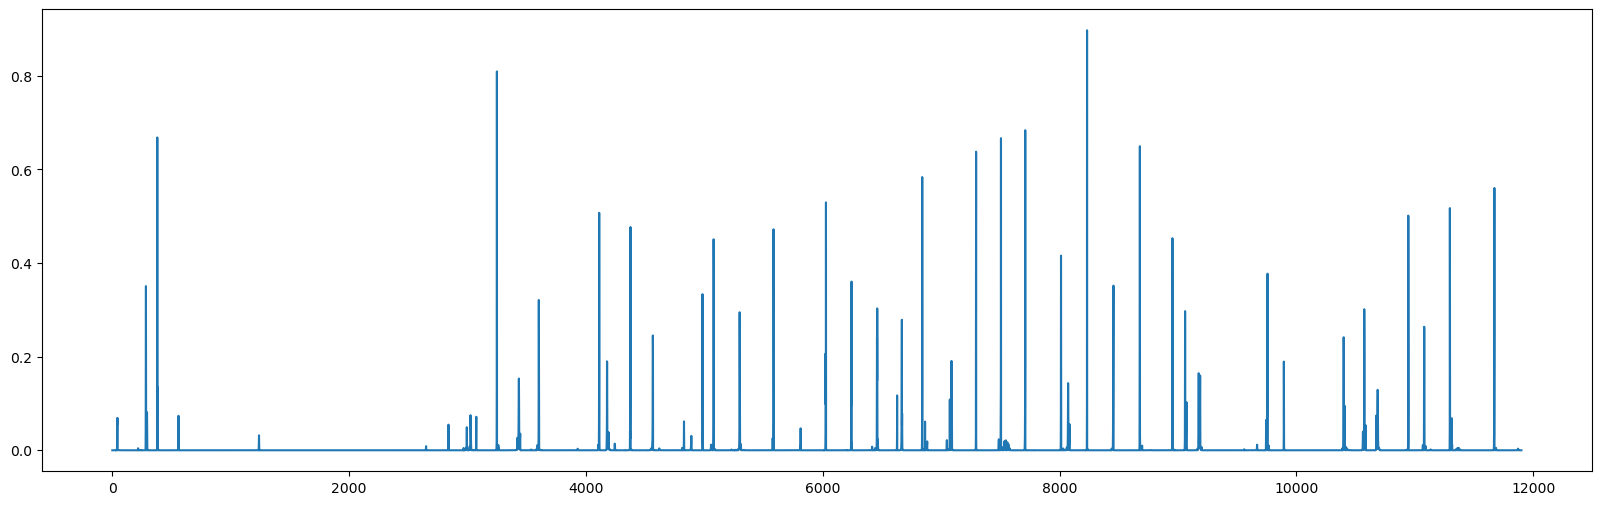

covering score: 0.5256228647612698
3 1 0 0


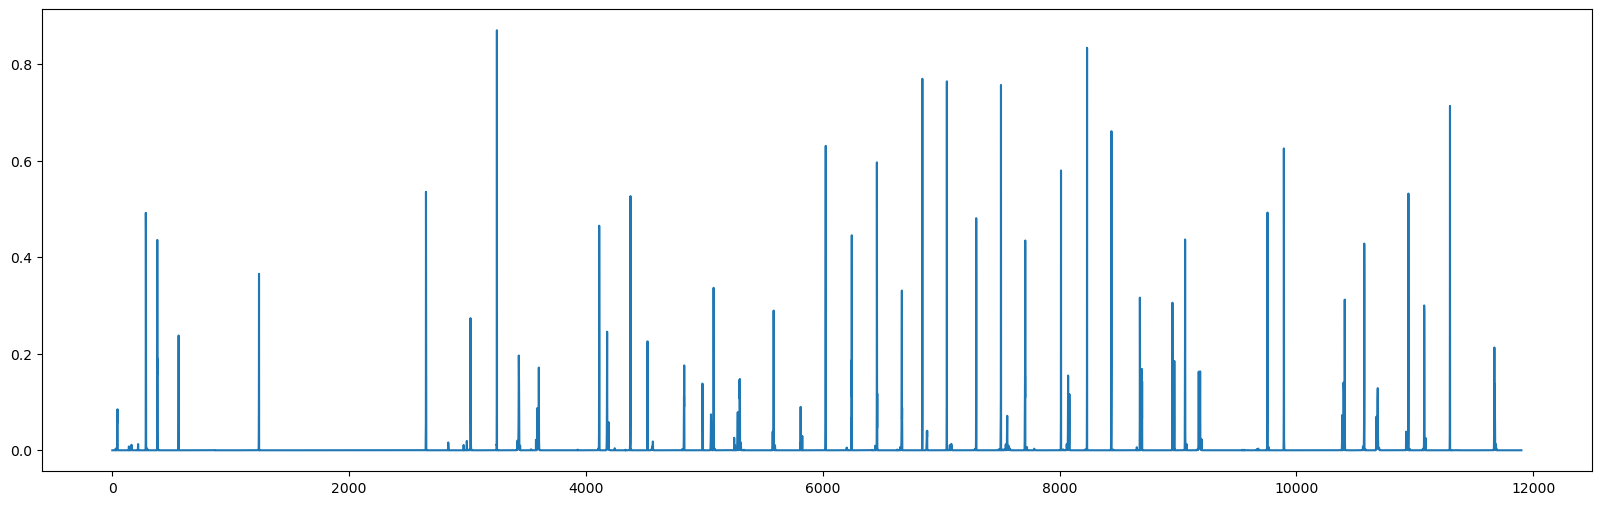

covering score: 0.4331485743033734
4 1 0 1


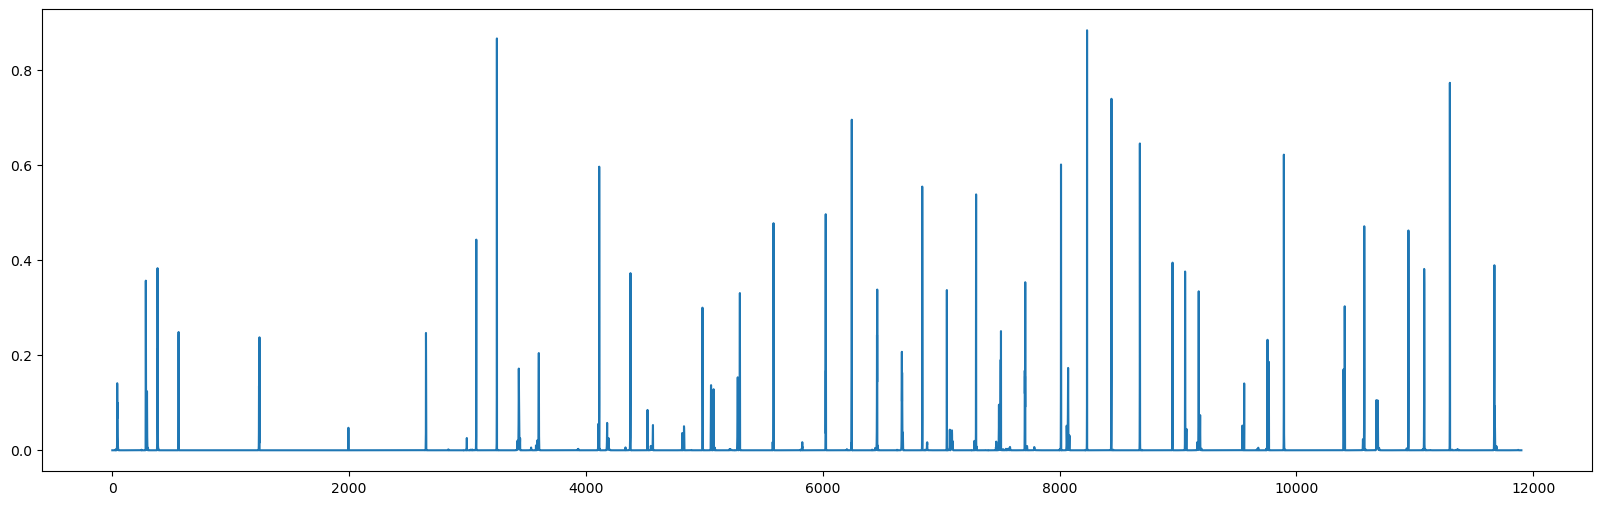

covering score: 0.4362136488625948
1 2 0 2


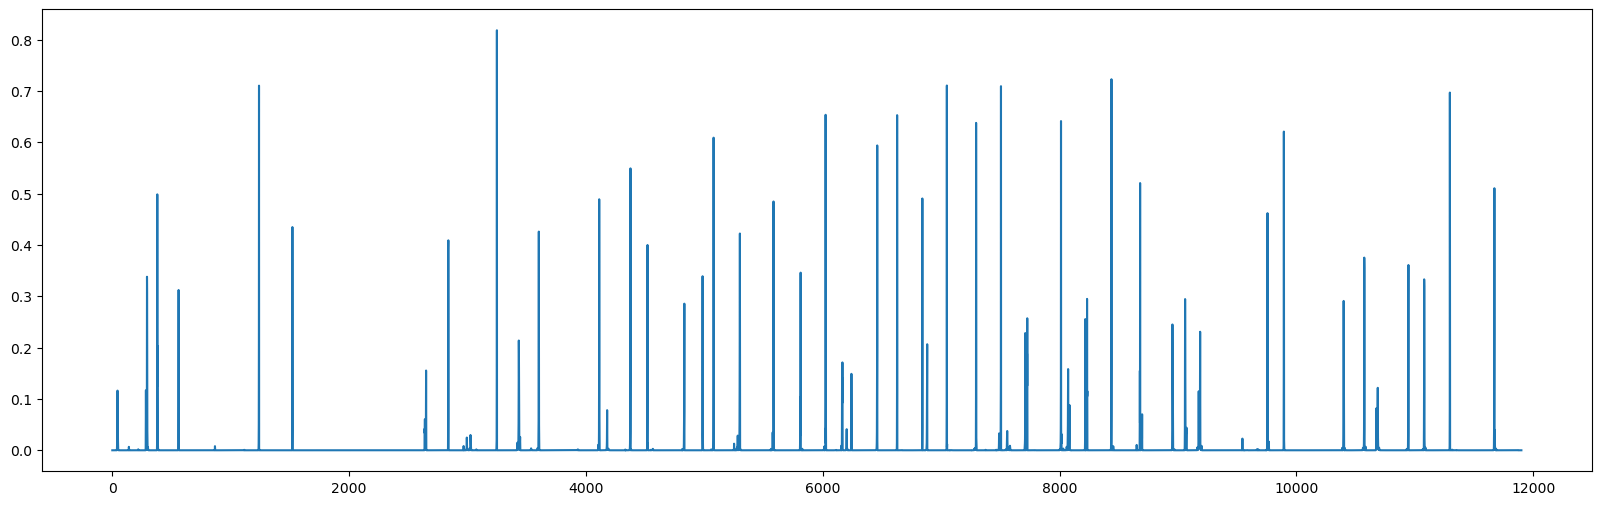

covering score: 0.33155570369135906
4 2 0 0


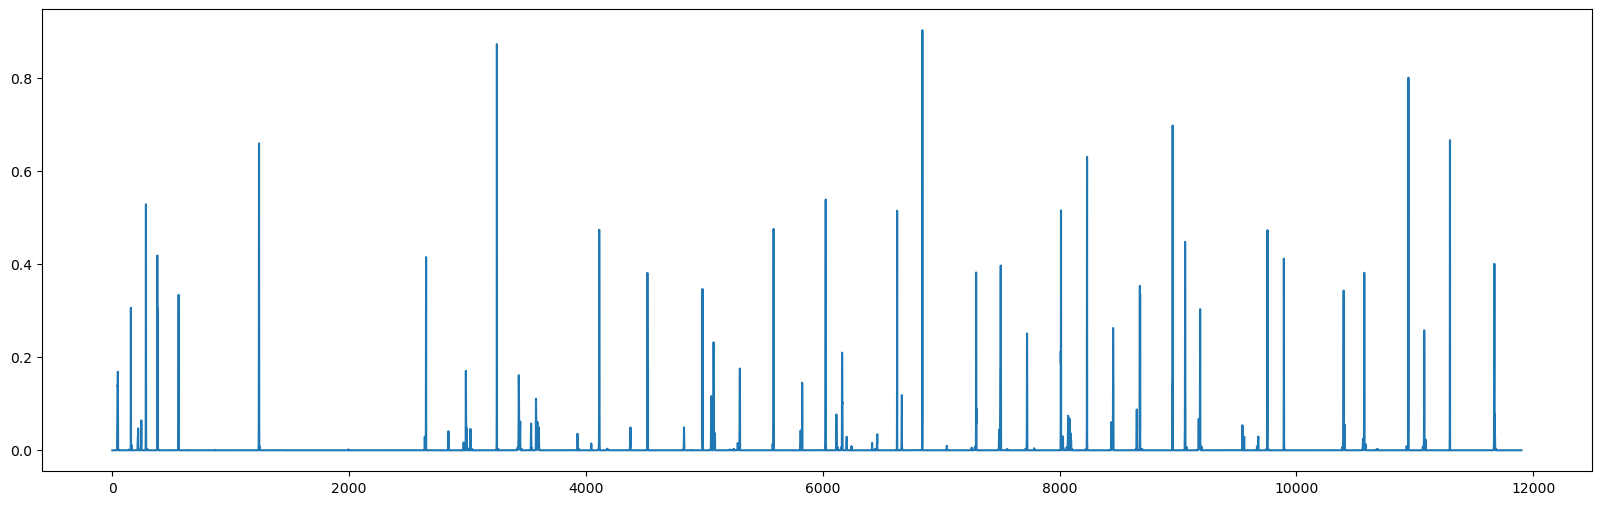

covering score: 0.34355470377468544
0 0 2 0


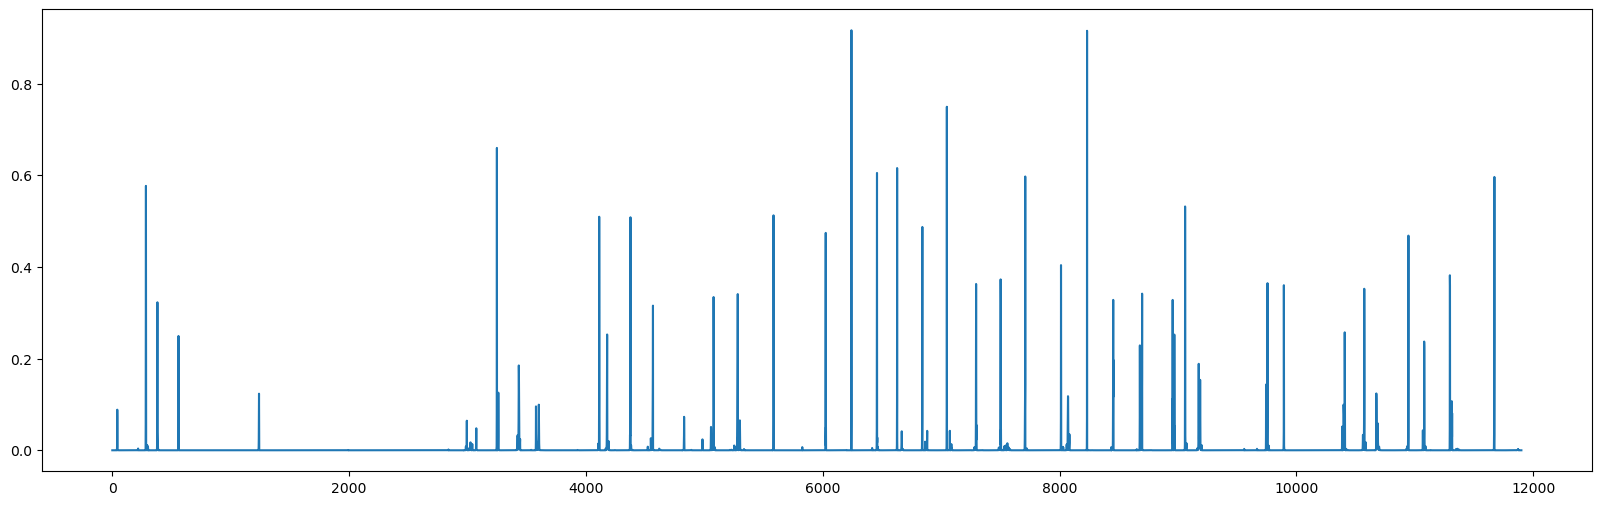

covering score: 0.5336221981501541
1 2 1 2


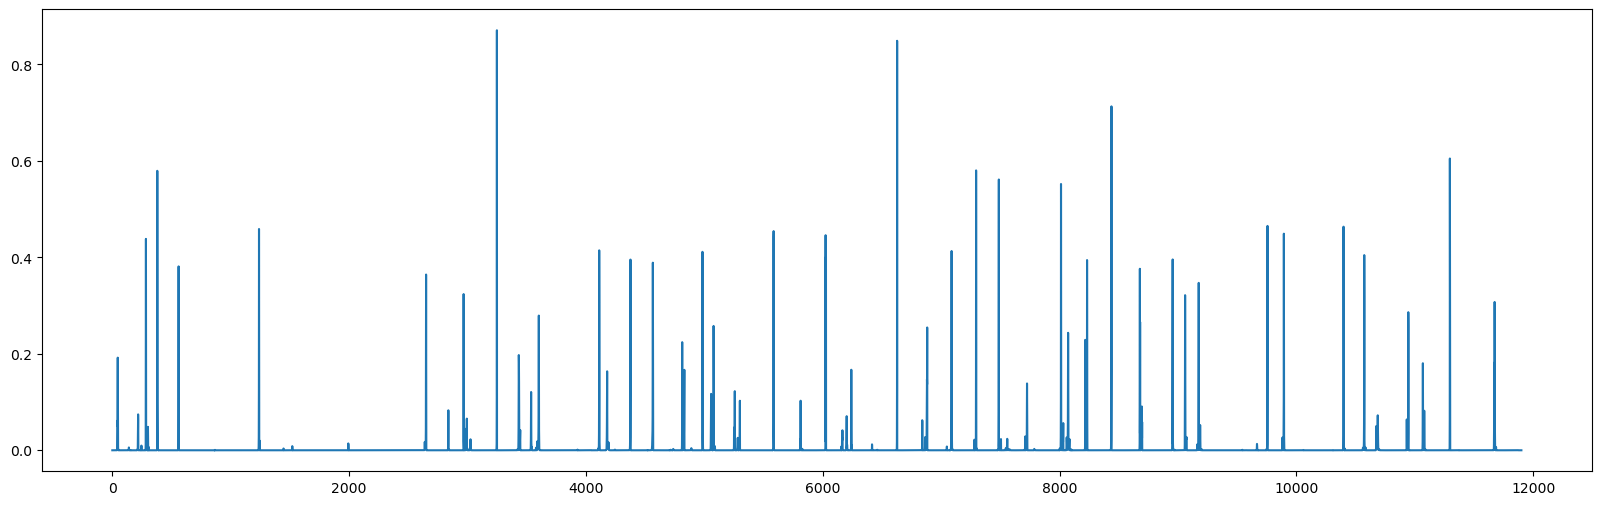

covering score: 0.4771269060911591
3 2 0 2


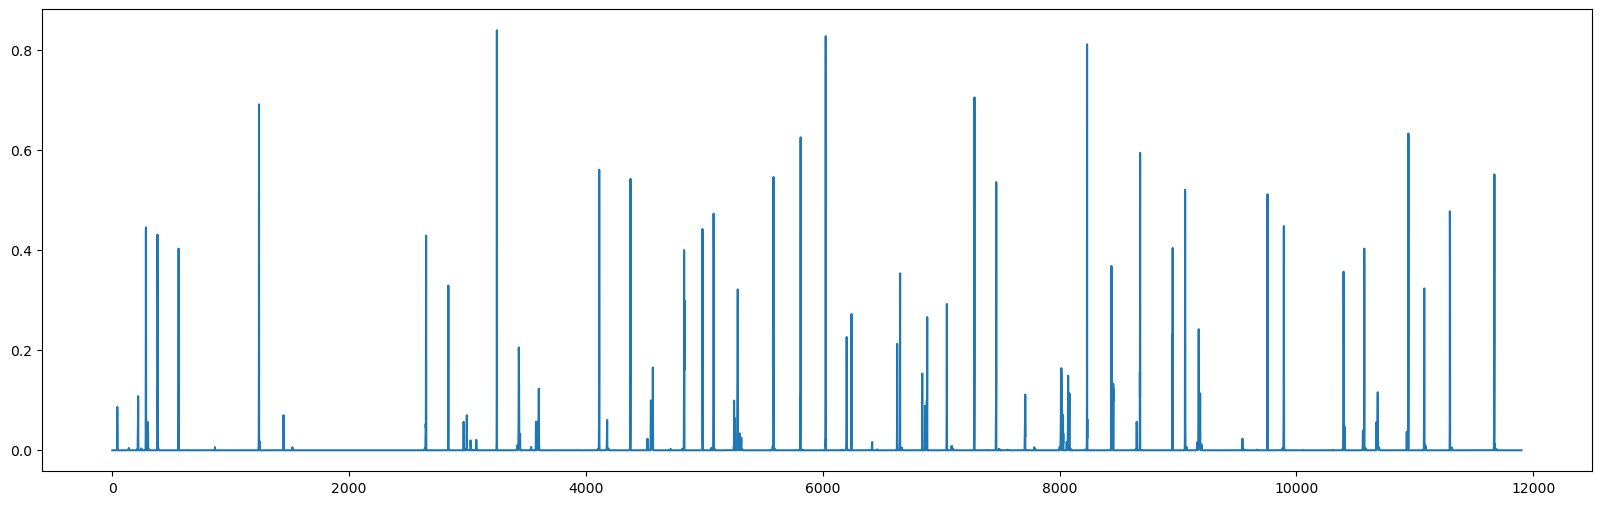

covering score: 0.39355053745521207
2 2 0 1


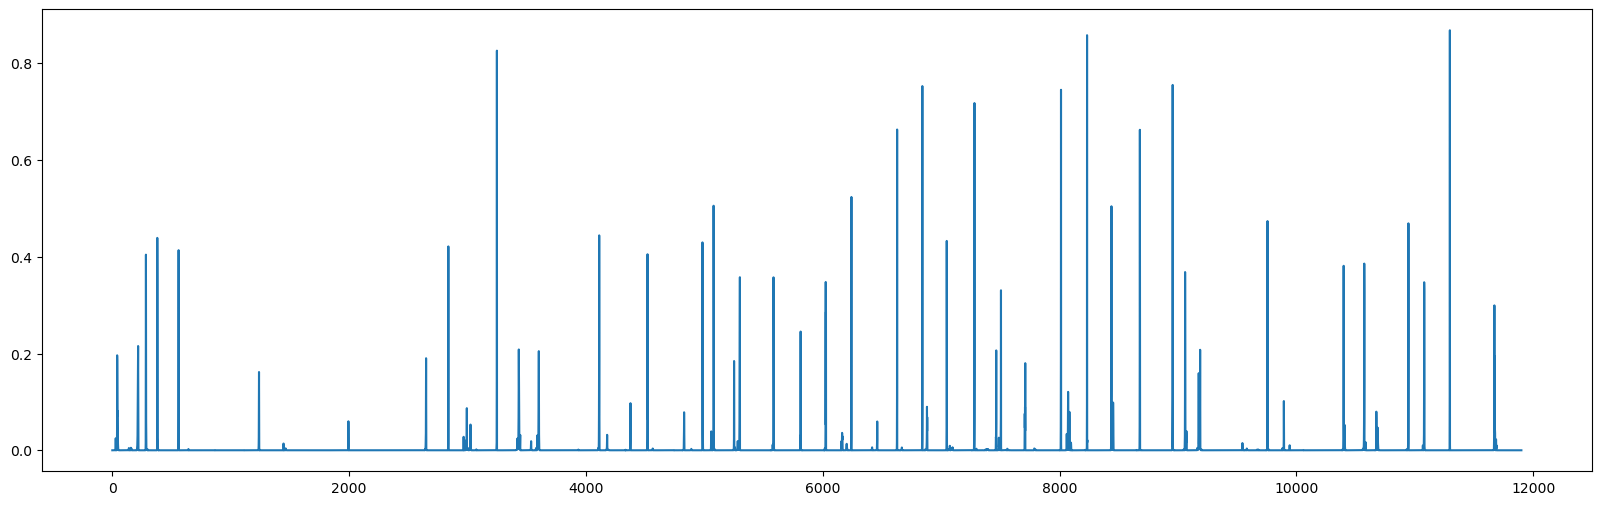

covering score: 0.5259561703191401
3 1 0 2


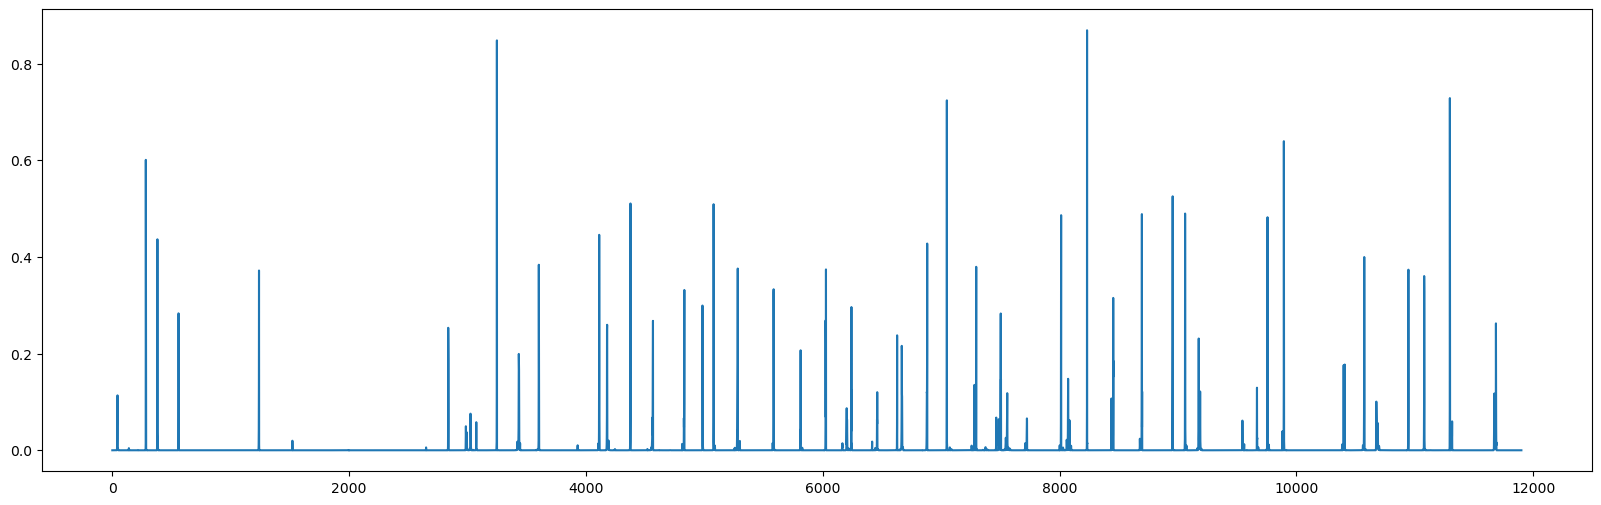

covering score: 0.509874177151904
3 0 2 1


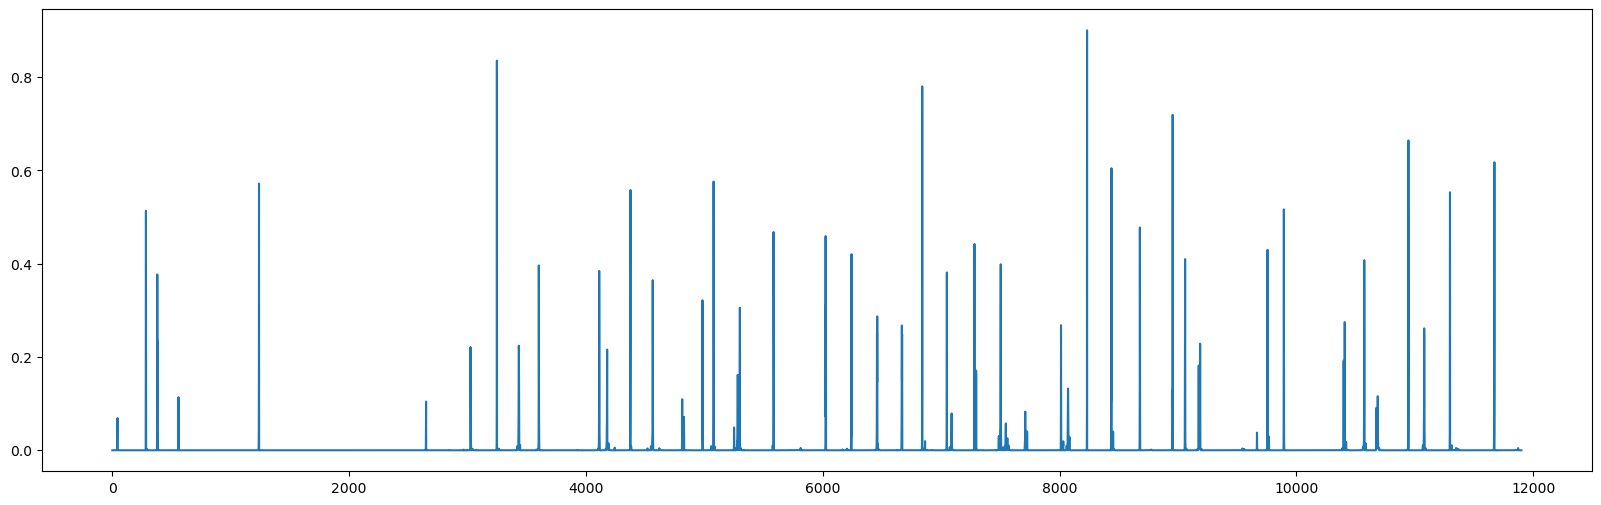

covering score: 0.39355053745521207


In [20]:
# Select ensemble size
n = 25

# Select dataset from 32 dataset repository:
ts = datasets[26]
ground_truth = ground_truths[26]


all_predictions = []
all_covering_scores = []

haz = len(ts)//5
predictions, covering_scores = UQTSS_BOCPD(ts, ground_truths[i], m_settings[i], n,[0.8*haz,0.9*haz,haz,1.1*haz,1.2*haz],[0.1,0.3,0.5])
flat_preds = np.array([])
for p in predictions:
    flat_preds = np.concatenate((flat_preds, p), axis=0)

all_predictions.append(flat_preds)
all_covering_scores.append(covering_scores)
        

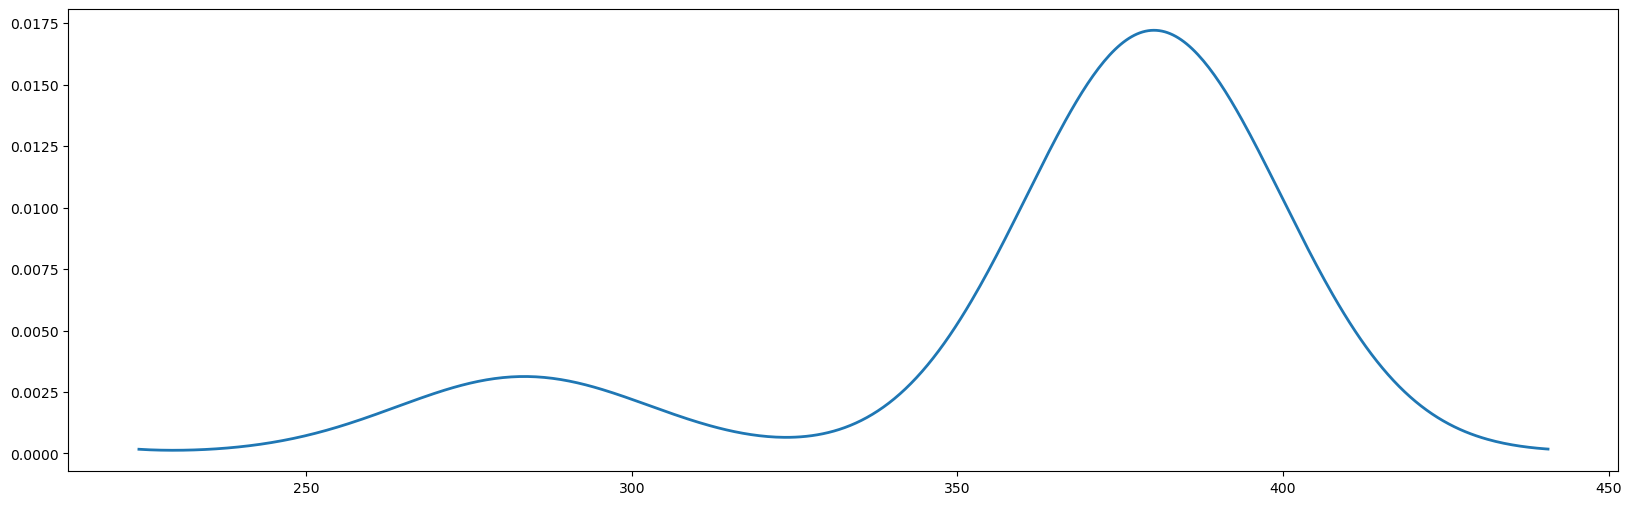

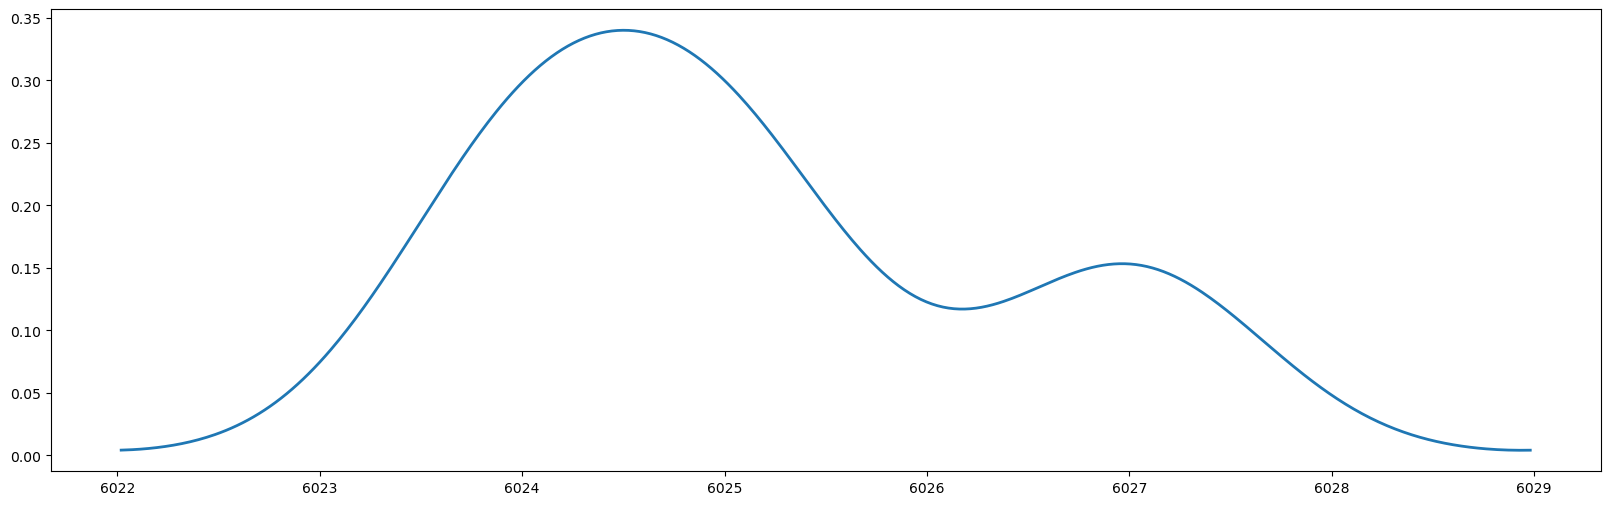

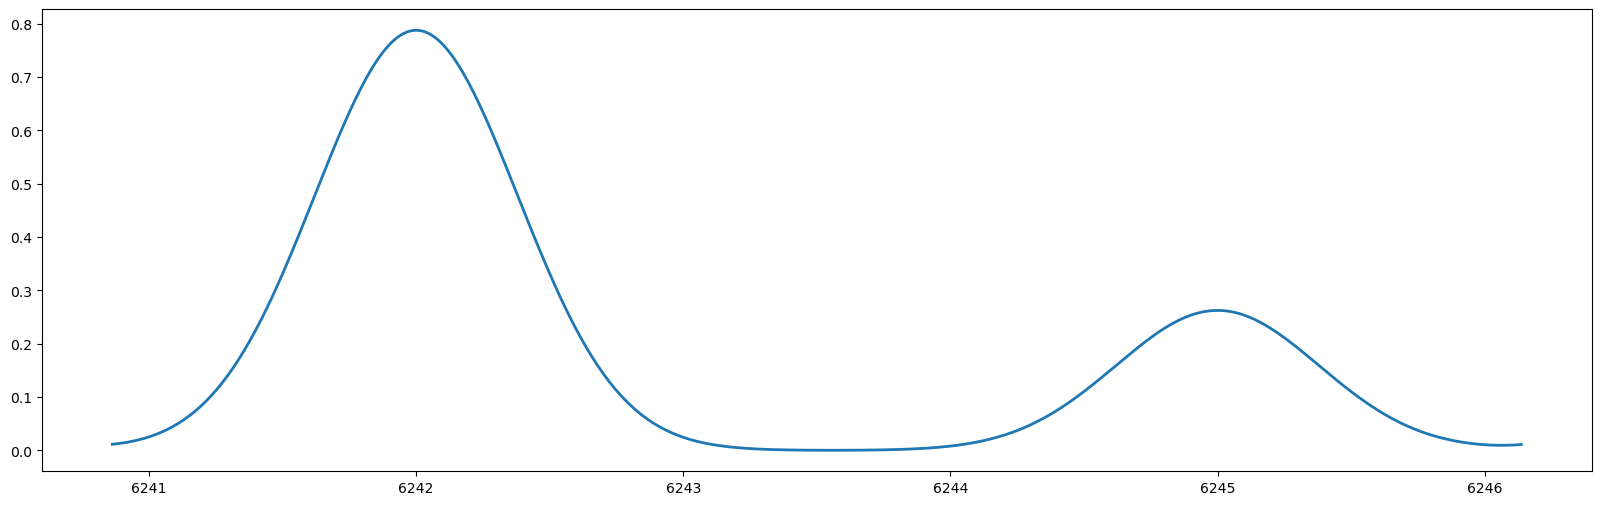

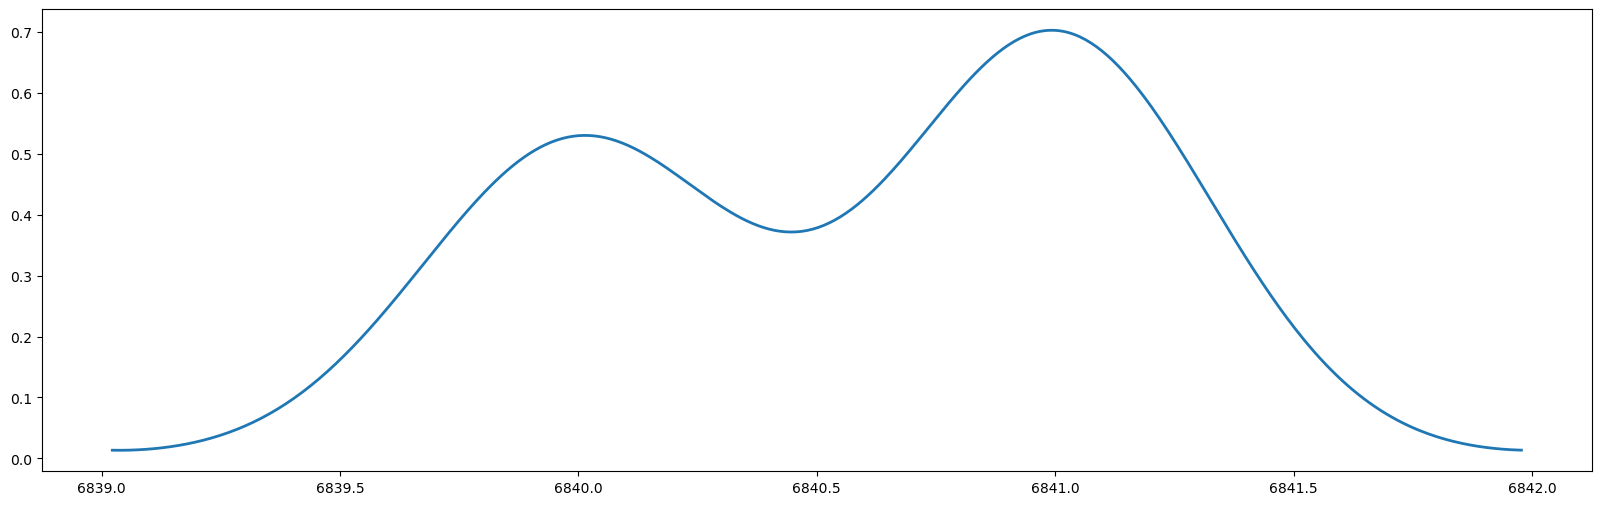

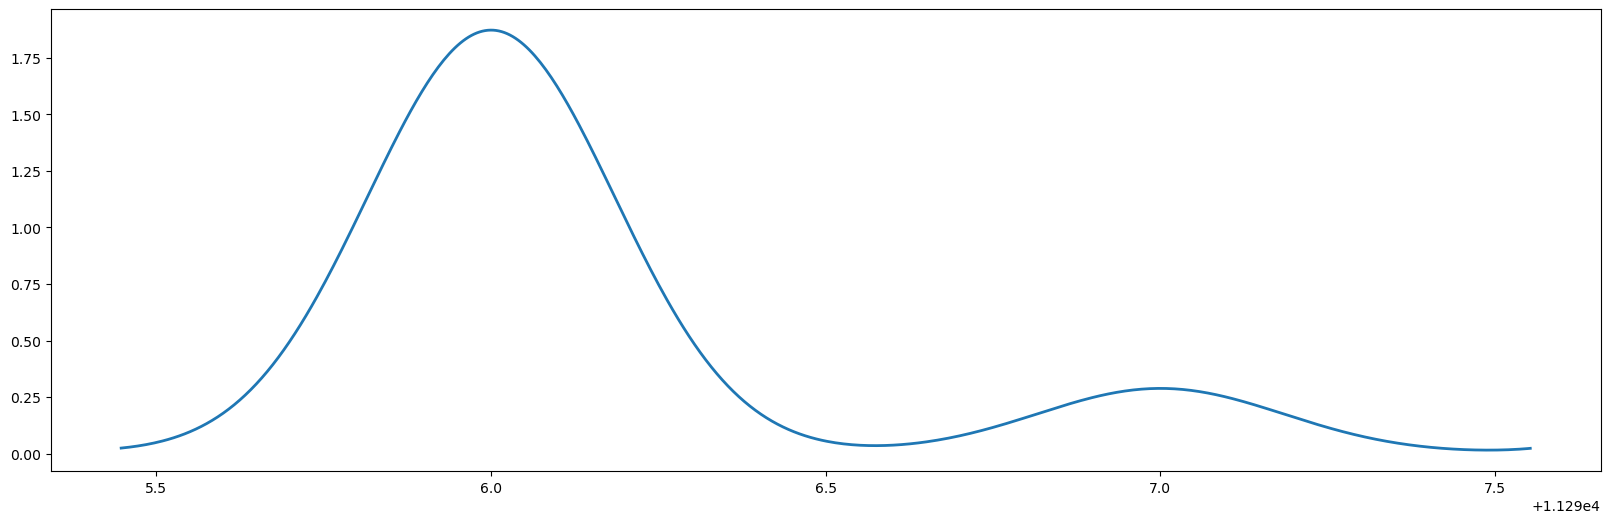

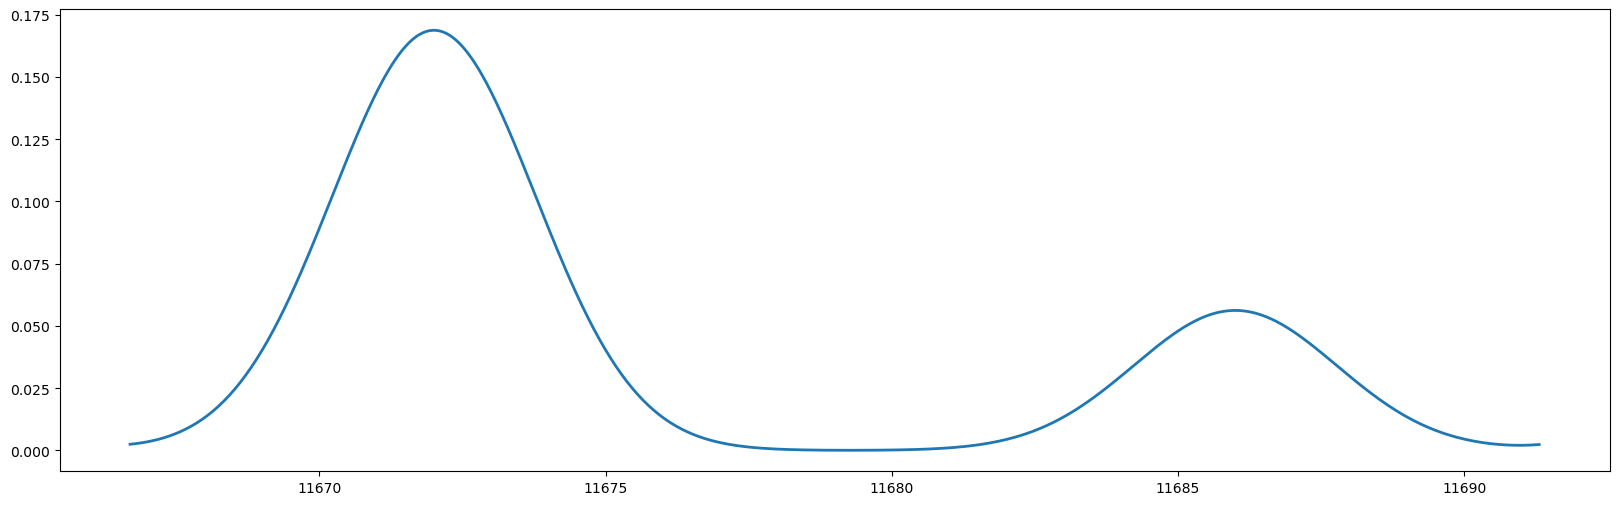

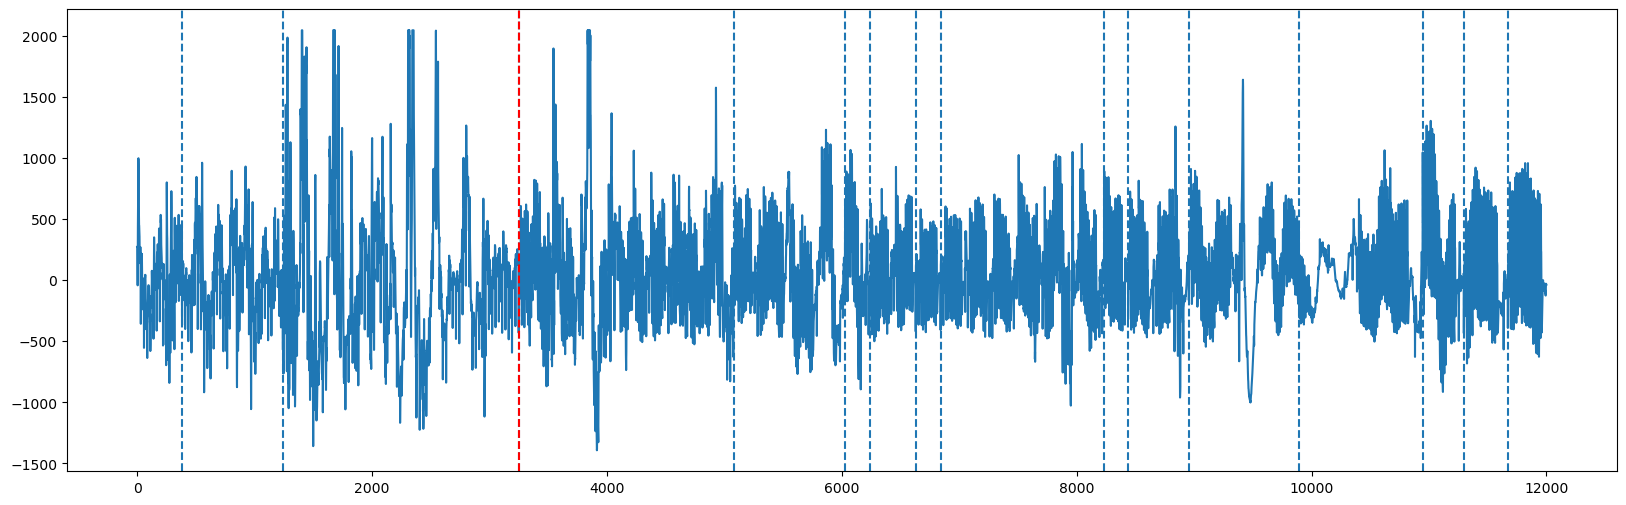

In [32]:
uqtss_covering = []
uqtss_uncertainties = []
uqtss_preds = []

for i,preds in enumerate(all_predictions):

    dbs = DBSCAN1D(eps=m_settings[i], min_samples=1)
    labels = dbs.fit_predict(preds)
  
    confidences = []
    uncertainties = []
    cp_locations_distributions = []
    
    strong_predictions = []
    for k in np.unique(labels):
        indexes = np.where(labels == k)[0]
        
        
        if len(preds[indexes]) >= int(0.15*n):
            confidences.append(len(indexes)/n)
            uncertainties.append(entropy([len(indexes)/n,1-len(indexes)/n],base=2))
            strong_predictions.append(int(np.round(np.median(preds[indexes]))))
            if (np.std(preds[indexes]) > 0):
                kde = sm.nonparametric.KDEUnivariate(preds[indexes])
                kde.fit(bw='silverman')  # Estimate the densities
                cp_locations_distributions.append(kde)
                plt.plot(kde.support, kde.density, lw=2, label="KDE from samples", zorder=10)
                plt.show()
    uqtss_uncertainties.append(np.median(uncertainties))
    strong_predictions = np.array(strong_predictions).flatten()
    
    plt.plot(ts)
    for regime_location in strong_predictions:
        plt.axvline(x=regime_location, linestyle="dashed")
    for regime_location in ground_truth:
        plt.axvline(x=regime_location, linestyle="dashed",color="red")
    plt.show()

    covering_score = covering(ground_truths[i], strong_predictions, len(datasets[0]))
    uqtss_covering.append(covering_score)

[0.7219280948873623]


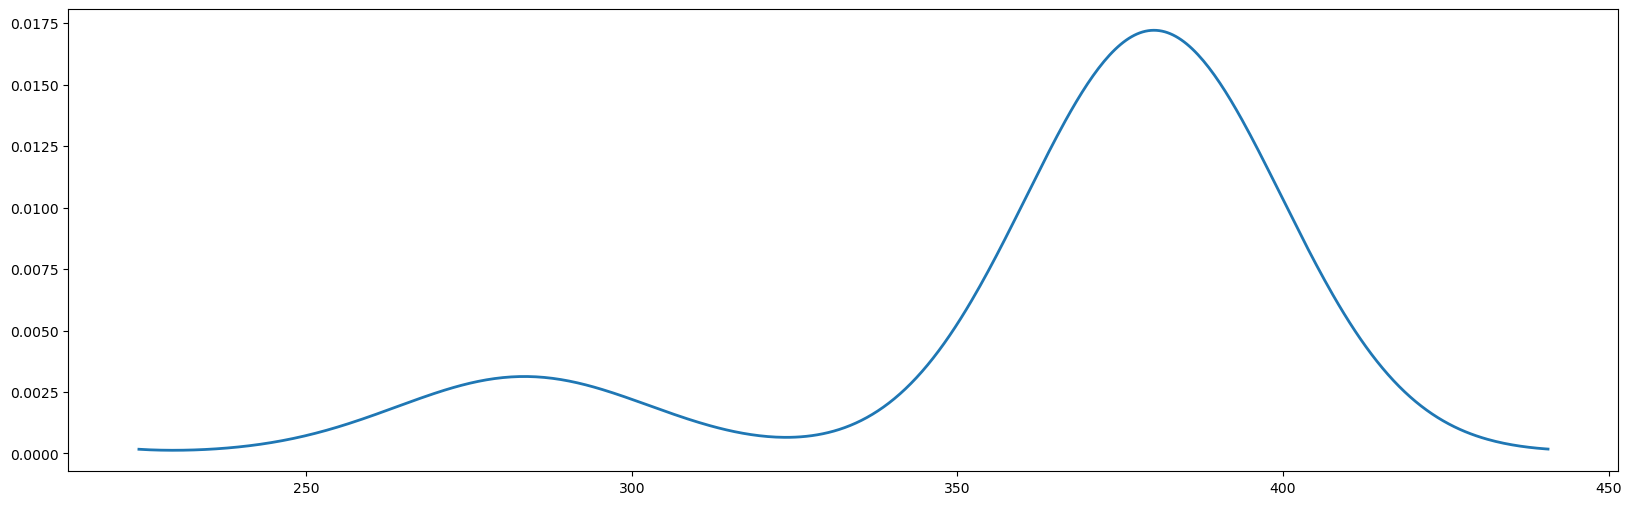

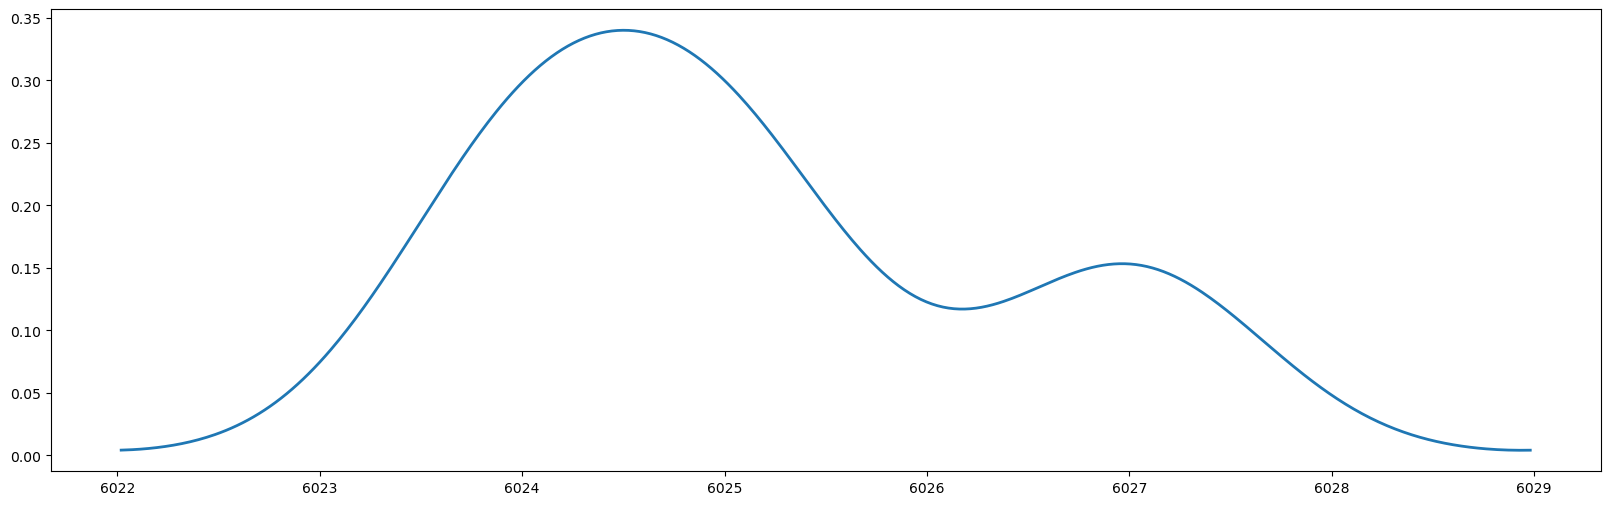

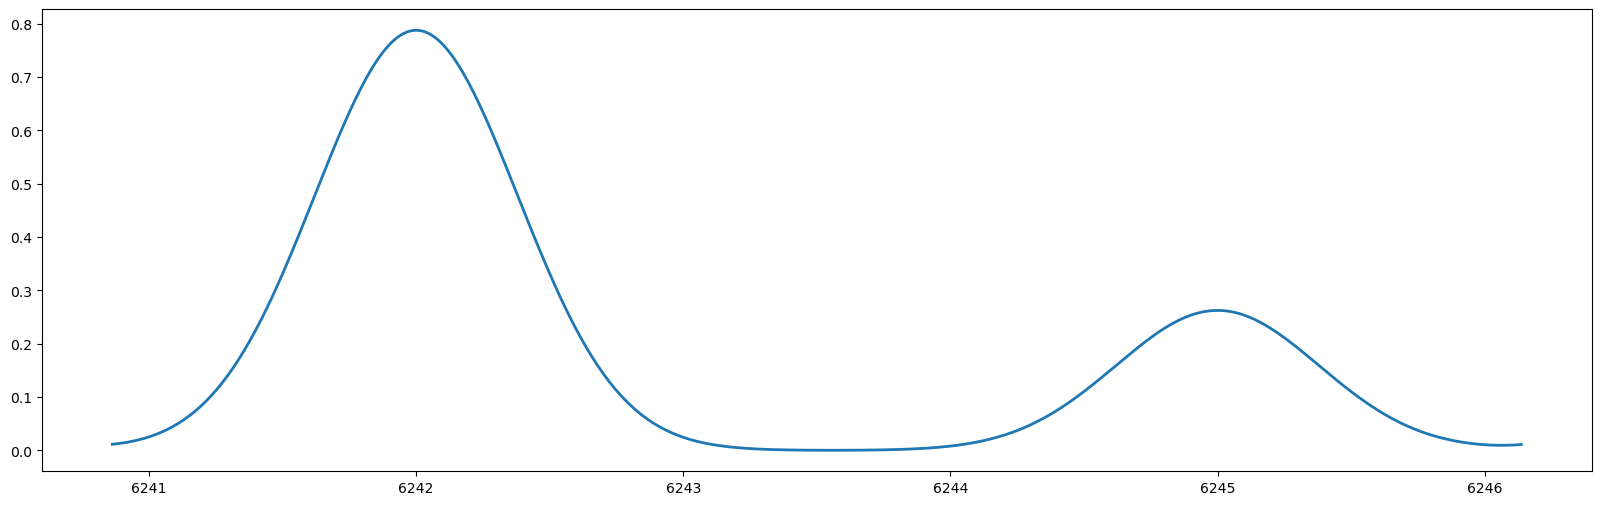

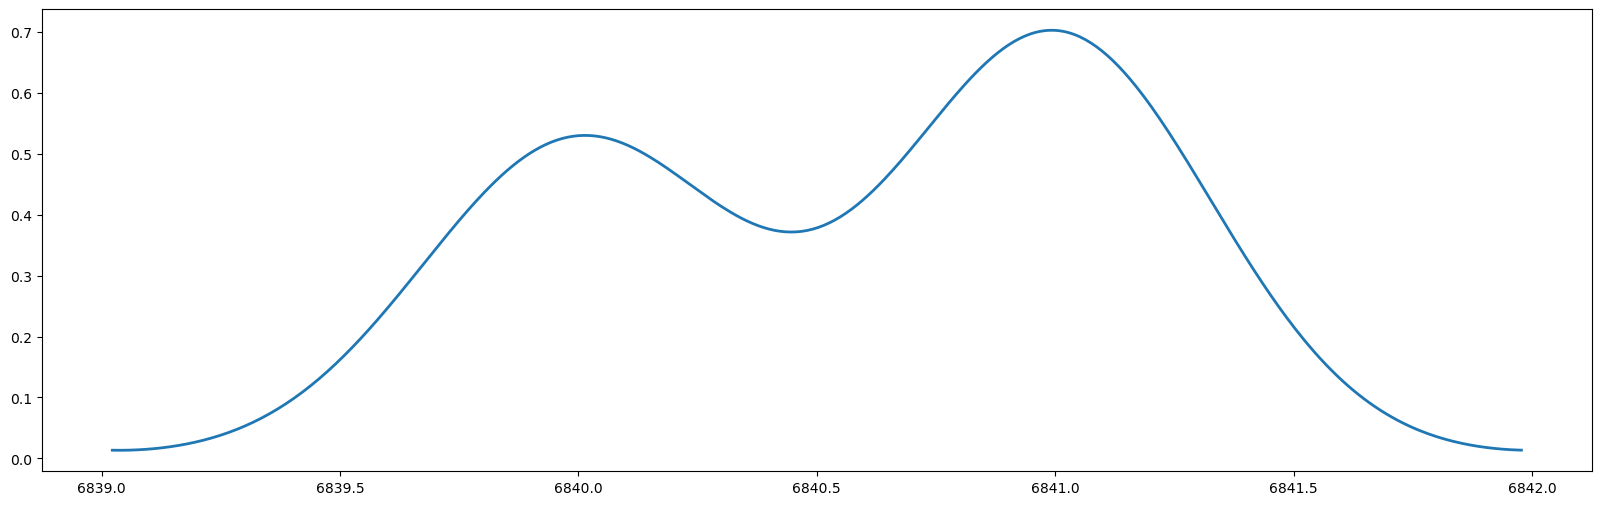

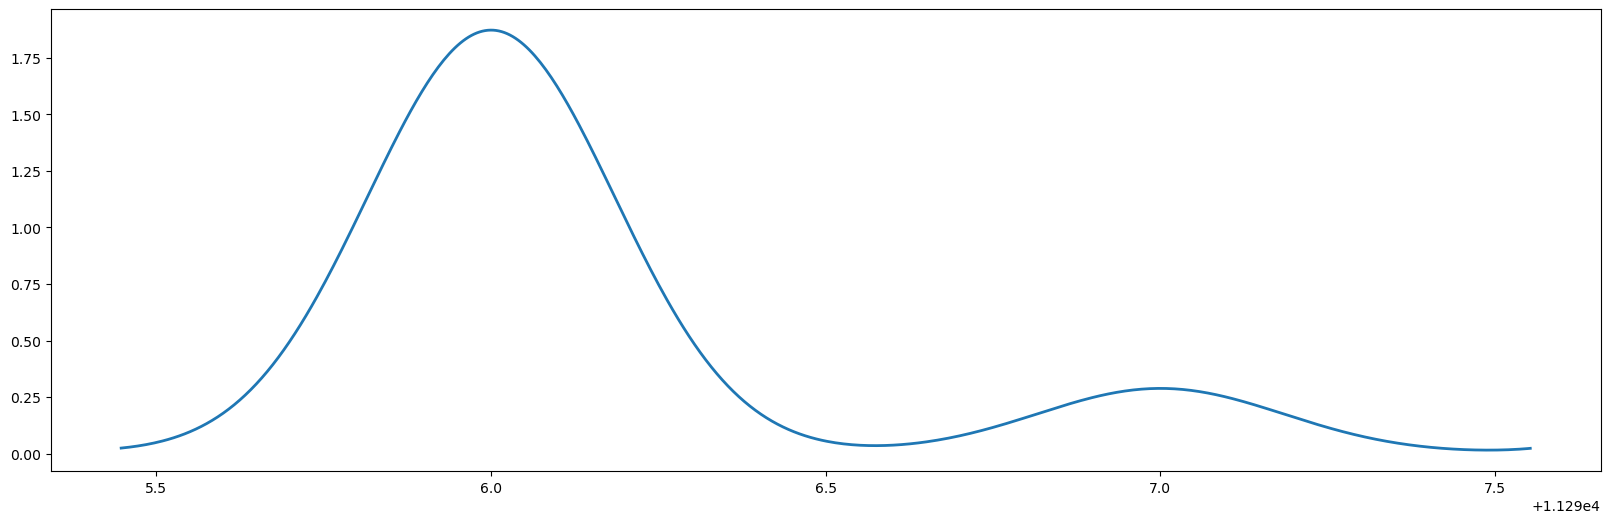

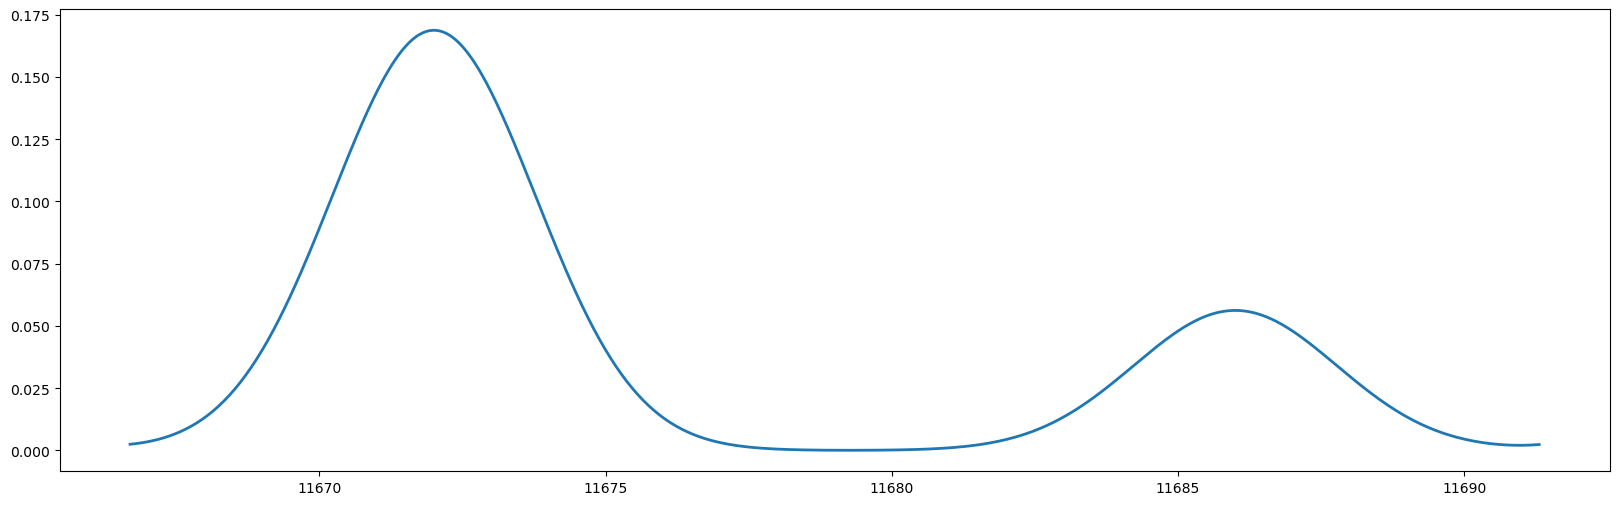

0.9988455359952018
0.7950402793845223
0.0
0.6343095546405662
0.9043814577244941
0.6343095546405662
0.6343095546405662
0.8554508105601307
0.9043814577244939
0.5293608652873644
0.6343095546405662
0.9895875212220555
0.7219280948873623
0.9709505944546688
0.6343095546405662
[  380  1239  3248  5078  6025  6242  6628  6841  8232  8438  8955  9894
 10946 11296 11672]


In [33]:
# Overall Uncertainty
print(uqtss_uncertainties)
# CP location probability distribution
for kde in cp_locations_distributions:
    plt.plot(kde.support, kde.density, lw=2, label="KDE from samples", zorder=10)
    plt.show()
# CP presence uncertainties
for uncertainty in uncertainties:
    print(uncertainty)
# Final CP predictions
print(strong_predictions)